In [1]:
import torch
import torch.autograd as autograd
import torch.nn.functional as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np
from torch.autograd import Variable
import matplotlib.gridspec as gridspec
import os
import numpy as np
from torch.autograd import Variable

import tensorflow as tf
#from torchvision import datasets, transforms

In [2]:
import torch
from torchvision import datasets

# Download MNIST data
mnist_train = datasets.MNIST(root='./data', train=True, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True)

# Extract data and labels
X_train = mnist_train.data.numpy()
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()


100%|██████████| 9.91M/9.91M [00:00<00:00, 138MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 18.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 72.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


In [3]:
# Check for GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# Load MNIST dataset

#mnist_data = tf.keras.datasets.mnist
#(X_train, y_train), (X_test, y_test) = mnist_data.load_data()

# Preprocess the data
X_train = X_train.reshape(-1, 28 * 28) / 255.0
X_test = X_test.reshape(-1, 28 * 28) / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
num_classes = 10 # There are 10 classes in MNIST
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes)

mb_size = 64
Z_dim = 100
X_dim = 28*28
y_dim = num_classes
h_dim = 128
cnt = 0
lr = 1e-3

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [5]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X, c):
    inputs = torch.cat([X, c], 1)
    h = nn.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params




In [ ]:
""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))

for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    idx = np.random.randint(0, X_train.shape[0], mb_size)
    X = Variable(torch.from_numpy(X_train[idx]).float())
    c = Variable(torch.from_numpy(y_train_one_hot[idx]).float())

    # Discriminator forward-loss-backward-update
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()
    reset_grad()

    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))



Iter-0; D_loss: 0.7683044672012329; G_loss: 1.8019037246704102
Iter-1000; D_loss: 0.7568037509918213; G_loss: 3.073835849761963
Iter-2000; D_loss: 0.7473157644271851; G_loss: 2.590235471725464
Iter-3000; D_loss: 0.80072021484375; G_loss: 2.3698554039001465
Iter-4000; D_loss: 0.5905004739761353; G_loss: 1.917833924293518
Iter-5000; D_loss: 0.7188234329223633; G_loss: 2.380314826965332
Iter-6000; D_loss: 0.6910922527313232; G_loss: 1.7675220966339111
Iter-7000; D_loss: 0.8030408620834351; G_loss: 2.2878246307373047
Iter-8000; D_loss: 0.8945662975311279; G_loss: 1.951965570449829
Iter-9000; D_loss: 0.7293336391448975; G_loss: 1.8575310707092285
Iter-10000; D_loss: 0.8266180157661438; G_loss: 1.6047744750976562
Iter-11000; D_loss: 0.9792320728302002; G_loss: 1.9361038208007812
Iter-12000; D_loss: 0.6811231970787048; G_loss: 1.8578519821166992
Iter-13000; D_loss: 0.8095341920852661; G_loss: 1.653957724571228
Iter-14000; D_loss: 0.7742702960968018; G_loss: 2.0016396045684814
Iter-15000; D_lo

Enter a digit between 0 and 9: 9


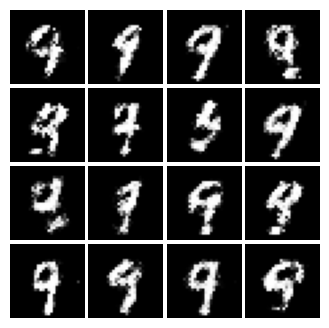

In [7]:
# ===================== AFTER TRAINING ========================

# Let the user choose a digit
chosen_digit = int(input("Enter a digit between 0 and 9: "))

# Create 16 copies of the one-hot vector for the chosen digit
c = np.zeros((16, y_dim), dtype='float32')
c[:, chosen_digit] = 1.
c = Variable(torch.from_numpy(c))

# Generate 16 latent vectors
z = Variable(torch.randn(16, Z_dim))

# Generate 16 samples
samples = G(z, c).data.numpy()

# Plot the 4x4 grid
fig = plt.figure(figsize=(4, 4))
gs = plt.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i in range(16):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(samples[i].reshape(28, 28), cmap='Greys_r')

# Save the image
if not os.path.exists('out/'):
    os.makedirs('out/')
plt.savefig(f'out/generated_grid_digit_{chosen_digit}.png', bbox_inches='tight')
plt.show()
